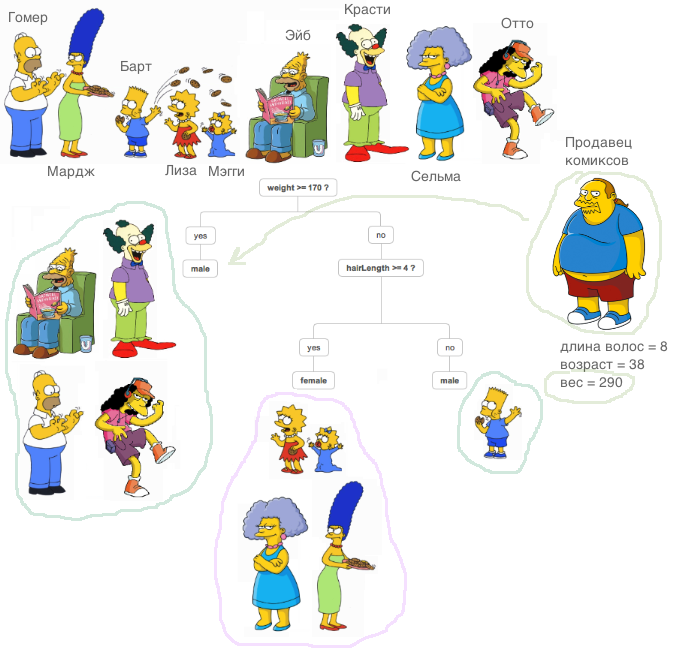

Статья: https://habr.com/ru/company/mailru/blog/438560/

Привет, Хабр!

После многочисленных поисков качественных руководств о решающих деревьях и ансамблевых алгоритмах (бустинг, решающий лес и пр.) с их непосредственной реализацией на языках программирования, и так ничего не найдя (кто найдёт — напишите в комментах, может, что-то новое почерпну), я решил сделать своё собственное руководство, каким бы я хотел его видеть. Задача на словах простая, но, как известно, дьявол кроется в мелочах, коих в алгоритмах с деревьями очень много.

Так как тема достаточно обширная, то очень сложно будет уместить всё в одну статью, поэтому будет две публикации: первая посвящена деревьям, а вторая часть будет посвящена реализации алгоритма градиентного бустинга. Весь изложенный здесь материал собран и оформлен на основе открытых источников, моего кода, кода коллег и друзей. Сразу предупреждаю, кода будет много.

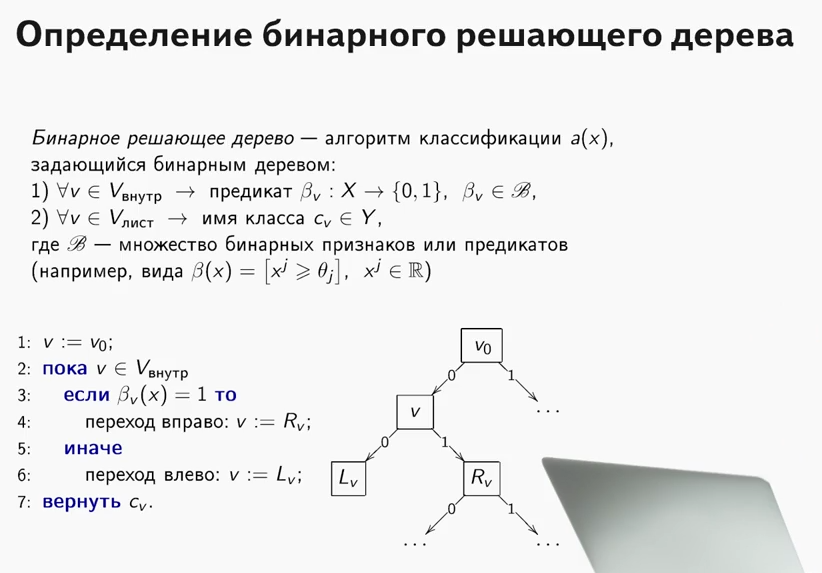

## Класс RegressionTree()

In [1]:
class RegressionTree():
    
    '''
    Класс RegressionTree решает задачу регрессии. Основан на рекурсивных
    вызовах, когда прописываются условия выхода из рекурсии. 
    '''
    
    def __init__(self, max_depth=3, n_epoch=10, min_size=8):
        
        '''
        Объявляем переменные класса.
        '''
        
        self.max_depth = max_depth # максимальная глубина
        self.min_size = min_size # минимальный размер поддерева
        self.value = 0 # значение в поддереве (среднее по всем листьям)
        self.feature_idx = -1 # номер лучшего признака
        self.feature_threshold = 0 # значение лучшего признака
        self.left = None # левый потомок
        self.right = None # правый потомок
        
    def fit(self, X, y):
        
        '''
        Процедура обучения дерева. На выходе получим обученную модель.
        '''
        
        # инициализируем начальные значения
        self.value = y.mean()
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0
        
        # ошибки в левом и правом поддереве
        prev_error_left = base_error
        prev_error_right = 0
        
        # если дошли до глубины 0 - выходим
        if self.max_depth <= 1:
            return
    
        dim_shape = X.shape[1]
        
        # значения в левом и правом поддереве
        left_value = 0
        right_value = 0
        
        # начинаем цикл по признакам
        for feat in range(dim_shape):
            
            # сортируем признаки
            idxs = np.argsort(X[:, feat])
            
            # количество сэмплов в левом и правом поддереве
            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1
            
            # начинаем проходиться по значениям признака
            while thres < N - 1:
                N1 -= 1
                N2 += 1
                
                idx = idxs[thres]
                x = X[idx, feat]
                
                # пропускаем одинаковые признаки
                if thres < N - 1 and x == X[idxs[thres + 1], feat]:

                    thres += 1
                    continue
                
                # данные, которые получаются у нас в результате такого сплита
                target_right = y[idxs][:thres]
                target_left = y[idxs][thres:]
                mean_right = y[idxs][:thres].mean(), 
                mean_left = y[idxs][thres:].mean()
                
                # на этом шаге уже нужно считать ошибку - 
                # генерируем предикты (среднее в потомках)
                left_shape = target_left.shape[0]
                right_shape = target_right.shape[0]
                mean_left_array = [mean_left for _ in range(left_shape)]
                mean_right_array = [mean_right for _ in range(right_shape)]
                
                # считаем ошибку слева и справа
                prev_error_left = N1/N * mse(target_left, mean_left_array) 
                prev_error_right = N2/N * mse(target_right, mean_right_array)
                
                # если выполняются условия сплита, то обновляем
                if (prev_error_left + prev_error_right < error):
                        if (min(N1,N2) > self.min_size):
                            self.feature_idx = feat
                            self.feature_threshold = x
                            left_value = mean_left
                            right_value = mean_right

                            flag = 1
                            error = prev_error_left + prev_error_right
                                     
                thres += 1
        
        # если не нашли лучший сплит, выходим
        if self.feature_idx == -1:
            return
        
        # дошли сюда - есть хорошее разбиение, нужно обучать дальше
        # инициализируем потомков - те же деревья решений
        self.left = RegressionTree(self.max_depth - 1)
        self.left.value = left_value
        self.right = RegressionTree(self.max_depth - 1)
        self.right.value = right_value
        
        # индексы потомков
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
        
        # обучаем
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
    def __predict(self, x):
        
        '''
        Функция для генерирования предсказания - смотрим узлы, идем 
        в соответствующих  потомков и смотрим в конце self.value - это
        и будет ответом.
        '''
        
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        
        '''
        Предикт для матрицы - просто для каждой строчки вызываем __predict().
        '''
        
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

Вкратце поясню, что здесь делает каждый метод.

Метод fit, как понятно из названия, обучает модель. На вход подаётся обучающая выборка и происходит процедура обучения дерева. Сортируя признаки, мы ищем наилучшее разбиение дерева с точки зрения уменьшения энтропии, в данном случае mse. Определить, что удалось найти хороший сплит, очень просто, достаточно выполнения двух условий. Мы не хотим, чтобы в разбиение попадало мало объектов (защита от переобучения), и средневзвешенная ошибка по mse должна быть меньше той ошибки, которая есть сейчас в дереве — мы ищем тот самый прирост information gain. Пройдя таким образом все признаки и все уникальные значения по ним, мы переберём все варианты и выберем наилучшее разбиение. А дальше делаем рекурсивный вызов на полученных разбиениях до тех пор, пока не выполнятся условия выхода из рекурсии.

Метод __predict, как понятно из названия, делает предикт. Получив на вход объект, он идёт по узлам полученного дерева — в каждом узле зафиксирован номер признака и значение по нему, и в зависимости от того, какое значение у поступившего метода объекта по этому признаку, мы идём либо в правого потомка, либо в левого, пока не дойдём до листа, в котором и будет ответ для данного объекта.

Метод predict делает то же самое, что и прошлый метод, только для группы объектов.

Импортируем всем известный набор данных о домах в Калифорнии. Это обычный датасет с данными и таргетом для решения задачи регрессии.

In [2]:
data = datasets.fetch_california_housing()
X = np.array(data.data)
y = np.array(data.target)

NameError: name 'datasets' is not defined

Что ж, давайте начнём сравнение! Для начала посмотрим, насколько быстро алгоритм обучается. Зададим у себя и в Sklearn единственный параметр max_depth, пусть он будет равен 2.

In [3]:
%%time
A = RegressionTree(2) # это наш алгоритм
A.fit(X,y)

NameError: name 'X' is not defined

In [5]:
from sklearn.tree import DecisionTreeRegressor
%time
model = DecisionTreeRegressor(max_depth=2)
 # из Sklearn
model.fit(X,y)

Wall time: 0 ns


NameError: name 'X' is not defined

Как видите, алгоритм обучается в тысячи раз медленне. В чём причина? Давайте разбираться.

Улучшение

## Класс RegressionTree() с быстрым пересчётом ошибки

In [6]:
class RegressionTreeFastMse():
    
    '''
    Класс RegressionTree с быстрым пересчетом ошибки. Сложность пересчета ошибки
    на каждой итерации составляет O(1).
    '''
    
    # объявляем характеристики класса
    def __init__(self, max_depth=3, min_size=10):
        
        self.max_depth = max_depth
        self.min_size = min_size
        self.value = 0
        self.feature_idx = -1
        self.feature_threshold = 0
        self.left = None
        self.right = None
        
    # процедура обучения - сюда передается обучающая выборка
    def fit(self, X, y):
        
        # начальное значение - среднее значение y
        self.value = y.mean()
        # начальная ошибка - mse между значением в листе (пока нет
        # разбиения, это среднее по всем объектам) и объектами
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0
        
        # пришли в максимальную глубину
        if self.max_depth <= 1:
            return
    
        dim_shape = X.shape[1]
        
        left_value, right_value = 0, 0
        
        for feat in range(dim_shape):
            
            prev_error1, prev_error2 = base_error, 0 
            idxs = np.argsort(X[:, feat])
            
            # переменные для быстрого переброса суммы
            mean1, mean2 = y.mean(), 0
            sm1, sm2 = y.sum(), 0
            
            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1

                idx = idxs[thres]
                x = X[idx, feat]
                
                # вычисляем дельты - по ним в основном будет делаться переброс
                delta1 = (sm1 - y[idx]) * 1.0 / N1 - mean1
                delta2 = (sm2 + y[idx]) * 1.0 / N2 - mean2
                
                # увеличиваем суммы
                sm1 -= y[idx]
                sm2 += y[idx]
                
                # пересчитываем ошибки за O(1)
                prev_error1 += (delta1**2) * N1 
                prev_error1 -= (y[idx] - mean1)**2 
                prev_error1 -= 2 * delta1 * (sm1 - mean1 * N1)
                mean1 = sm1/N1
                
                prev_error2 += (delta2**2) * N2 
                prev_error2 += (y[idx] - mean2)**2 
                prev_error2 -= 2 * delta2 * (sm2 - mean2 * N2)
                mean2 = sm2/N2
                
                # пропускаем близкие друг к другу значения
                if thres < N - 1 and np.abs(x - X[idxs[thres + 1], feat]) < 1e-5:
                    thres += 1
                    continue
                
                # 2 условия, чтобы осуществить сплит - уменьшение ошибки 
                # и минимальное кол-о эл-в в каждом листе
                if (prev_error1 + prev_error2 < error):
                    if (min(N1,N2) > self.min_size):
                    
                        # переопределяем самый лучший признак и границу по нему
                        self.feature_idx, self.feature_threshold = feat, x
                        # переопределяем значения в листах
                        left_value, right_value = mean1, mean2

                        # флаг - значит сделали хороший сплит
                        flag = 1
                        error = prev_error1 + prev_error2
                                     
                thres += 1
 
        # ничего не разделили, выходим
        if self.feature_idx == -1:
            return
        
        self.left = RegressionTreeFastMse(self.max_depth - 1)
        # print ("Левое поддерево с глубиной %d"%(self.max_depth - 1))
        self.left.value = left_value
        self.right = RegressionTreeFastMse(self.max_depth - 1)
        # print ("Правое поддерево с глубиной %d"%(self.max_depth - 1))
        self.right.value = right_value
        
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
    
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
    def __predict(self, x):
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

Измерим время, которое уходит теперь на обучение, и сравним с аналогом из Sklearn.

In [7]:
%time
A = RegressionTreeFastMse(4, min_size=5)
A.fit(X,y)
test_mytree = A.predict(X)
test_mytree

Wall time: 0 ns


NameError: name 'X' is not defined

In [8]:
%time
model = DecisionTreeRegressor(max_depth=4)
model.fit(X,y)
test_sklearn = model.predict(X)

Wall time: 0 ns


NameError: name 'X' is not defined

## Класс RegressionTree() с линейными комбинациями признаков

Замечу, что сложность алгоритма в этом случае возрастёт, понятно во сколько раз. Ну и чтобы считалось побыстрее, будем использовать cython.

In [9]:
%load_ext Cython

%%cython -a 

import itertools
import numpy as np
cimport numpy as np
from itertools import *

cdef class RegressionTreeCython:
    
    cdef public int max_depth
    cdef public int feature_idx
    cdef public int min_size
    cdef public int averages 
    
    cdef public np.float64_t feature_threshold
    cdef public np.float64_t value

    cpdef RegressionTreeCython left
    cpdef RegressionTreeCython right
    
    def __init__(self, max_depth=3, min_size=4, averages=1):
        
        self.max_depth = max_depth
        self.min_size = min_size
        self.value = 0
        self.averages = averages
        self.feature_idx = -1
        self.feature_threshold = 0
        self.left = None
        self.right = None
            

    def data_transform(self, np.ndarray[np.float64_t, ndim=2] X, list index_tuples):
        
        # преобразование данных - дополнение новыми признаками в виде суммы
        for i in index_tuples:
            # добавляем суммы, индексы которых переданы в качестве аргумента
            X = np.hstack((X, X[:, i[0]:(i[1]+1)].sum(axis=1).reshape(X.shape[0],1)))
        return X
    
    def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):

        cpdef np.float64_t mean1 = 0.0
        cpdef np.float64_t mean2 = 0.0
        cpdef long N = X.shape[0]
        cpdef long N1 = X.shape[0]
        cpdef long N2 = 0
        cpdef np.float64_t delta1 = 0.0
        cpdef np.float64_t delta2 = 0.0
        cpdef np.float64_t sm1 = 0.0
        cpdef np.float64_t sm2 = 0.0
        cpdef list index_tuples
        cpdef list stuff
        cpdef long idx = 0
        
        cpdef np.float64_t prev_error1 = 0.0
        cpdef np.float64_t prev_error2 = 0.0
        cpdef long thres = 0
        cpdef np.float64_t error = 0.0
        
        cpdef np.ndarray[long, ndim=1] idxs
        
        cpdef np.float64_t x = 0.0
        
        # такую процедуру необходимо сделать только один раз
        # генерируем индексы, по которым суммируем признаки
        if self.averages:
            stuff = list(range(0,X.shape[1],1))
            index_tuples = list(combinations(stuff,2))
            # выполняем преобразование данных
            X = self.data_transform(X, index_tuples)
            
        # начальное значение - среднее значение y
        self.value = y.mean()
        # начальная ошибка - mse между значением в листе (пока нет разбиения, 
        # это среднее по всем объектам) и объектами
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0
        
        # пришли на максимальную глубину
        if self.max_depth <= 1:
            return
    
        dim_shape = X.shape[1]
        
        left_value, right_value = 0, 0
        
        for feat in range(dim_shape):
            
            prev_error1, prev_error2 = base_error, 0 
            idxs = np.argsort(X[:, feat])
            
            # переменные для быстрого переброса суммы
            mean1, mean2 = y.mean(), 0
            sm1, sm2 = y.sum(), 0
            
            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1

                idx = idxs[thres]
                x = X[idx, feat]
                
                # вычисляем дельты - по ним в основном будет делаться переброс
                delta1 = (sm1 - y[idx]) * 1.0 / N1 - mean1
                delta2 = (sm2 + y[idx]) * 1.0 / N2 - mean2
                
                # увеличиваем суммы
                sm1 -= y[idx]
                sm2 += y[idx]
                
                # пересчитываем ошибки за O(1)
                prev_error1 += (delta1**2) * N1 
                prev_error1 -= (y[idx] - mean1)**2 
                prev_error1 -= 2 * delta1 * (sm1 - mean1 * N1)
                mean1 = sm1/N1
                
                prev_error2 += (delta2**2) * N2 
                prev_error2 += (y[idx] - mean2)**2 
                prev_error2 -= 2 * delta2 * (sm2 - mean2 * N2)
                mean2 = sm2/N2
                
                # пропускаем близкие друг к другу значения
                if thres < N - 1 and np.abs(x - X[idxs[thres + 1], feat]) < 1e-5:
                    thres += 1
                    continue
                
                # 2 условия осуществления сплита - уменьшение ошибки
                # и минимальное кол-во элементов в в каждом листе
                if (prev_error1 + prev_error2 < error):
                    if (min(N1,N2) > self.min_size):
                    
                        # переопределяем самый лучший признак и границу по нему
                        self.feature_idx, self.feature_threshold = feat, x
                        # переопределяем значения в листах
                        left_value, right_value = mean1, mean2

                        # флаг - значит сделали хороший сплит
                        flag = 1
                        error = prev_error1 + prev_error2
                                     
                thres += 1
        
        # self.feature_idx - индекс самой крутой разделяющей фичи. 
        # Если это какая-то из сумм, и если есть какое-то экспертное знание 
        # о данных, то интересно посмотреть, что значит эта сумма 
        
        # ничего не разделили, выходим
        if self.feature_idx == -1:
            return
        
        # вызываем потомков дерева
        self.left = RegressionTreeCython(self.max_depth - 1, averages=0)
        self.left.value = left_value
        self.right = RegressionTreeCython(self.max_depth - 1, averages=0)
        self.right.value = right_value
        
        # новые индексы для обучения потомков
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
        
        # обучение потомков
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
    def __predict(self, np.ndarray[np.float64_t, ndim=1] x):
        
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):

        # чтобы делать предикты, нужно также добавить суммы в тестовую выборку
        if self.averages:
            stuff = list(range(0,X.shape[1],1))
            index_tuples = list(itertools.combinations(stuff,2))
            X = self.data_transform(X, index_tuples)
            
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

SyntaxError: invalid syntax (<ipython-input-9-785b2d0ce9f3>, line 7)

## Сравнение результатов

In [10]:
from sklearn.model_selection import KFold

def get_metrics(X,y,n_folds=2, model=None):

    kf = KFold(n_splits=n_folds, shuffle=True)
    kf.get_n_splits(X)

    er_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
        er_list.append(mse(y_test, predict))
    
    return er_list

Теперь прогоним всех алгоритмы.

In [11]:
import matplotlib.pyplot as plt

data = datasets.fetch_california_housing()
X = np.array(data.data)
y = np.array(data.target)

er_sklearn_tree = get_metrics(X,y,30,DecisionTreeRegressor(max_depth=4, min_samples_leaf=10))
er_fast_mse_tree = get_metrics(X,y,30,RegressionTreeFastMse(4, min_size=10))
er_averages_tree = get_metrics(X,y,30,RegressionTreeCython(4, min_size=10))

%matplotlib inline
data = [er_sklearn_tree, er_fast_mse_tree, er_averages_tree]
fig7, ax7 = plt.subplots()
ax7.set_title('')
ax7.boxplot(data, labels=['Sklearn Tree', 'Fast Mse Tree', 'Averages Tree'])
plt.grid()
plt.show()

NameError: name 'datasets' is not defined

## Пишем XGBoost с нуля — часть 2: градиентный бустинг

В прошлой статье мы разбирались, как устроены решающие деревья, и с нуля реализовали
алгоритм построения, попутно оптимизируя и улучшая его.

В этой статье мы реализуем алгоритм градиентного бустинга и в конце создадим свой собственный XGBoost. Повествование будет идти по той же схеме: пишем алгоритм, описываем его, в заверешение подводим итоги, сравнивая результаты работы с аналогами из Sklearn'а.

Статья: https://habr.com/ru/company/mailru/blog/438562/

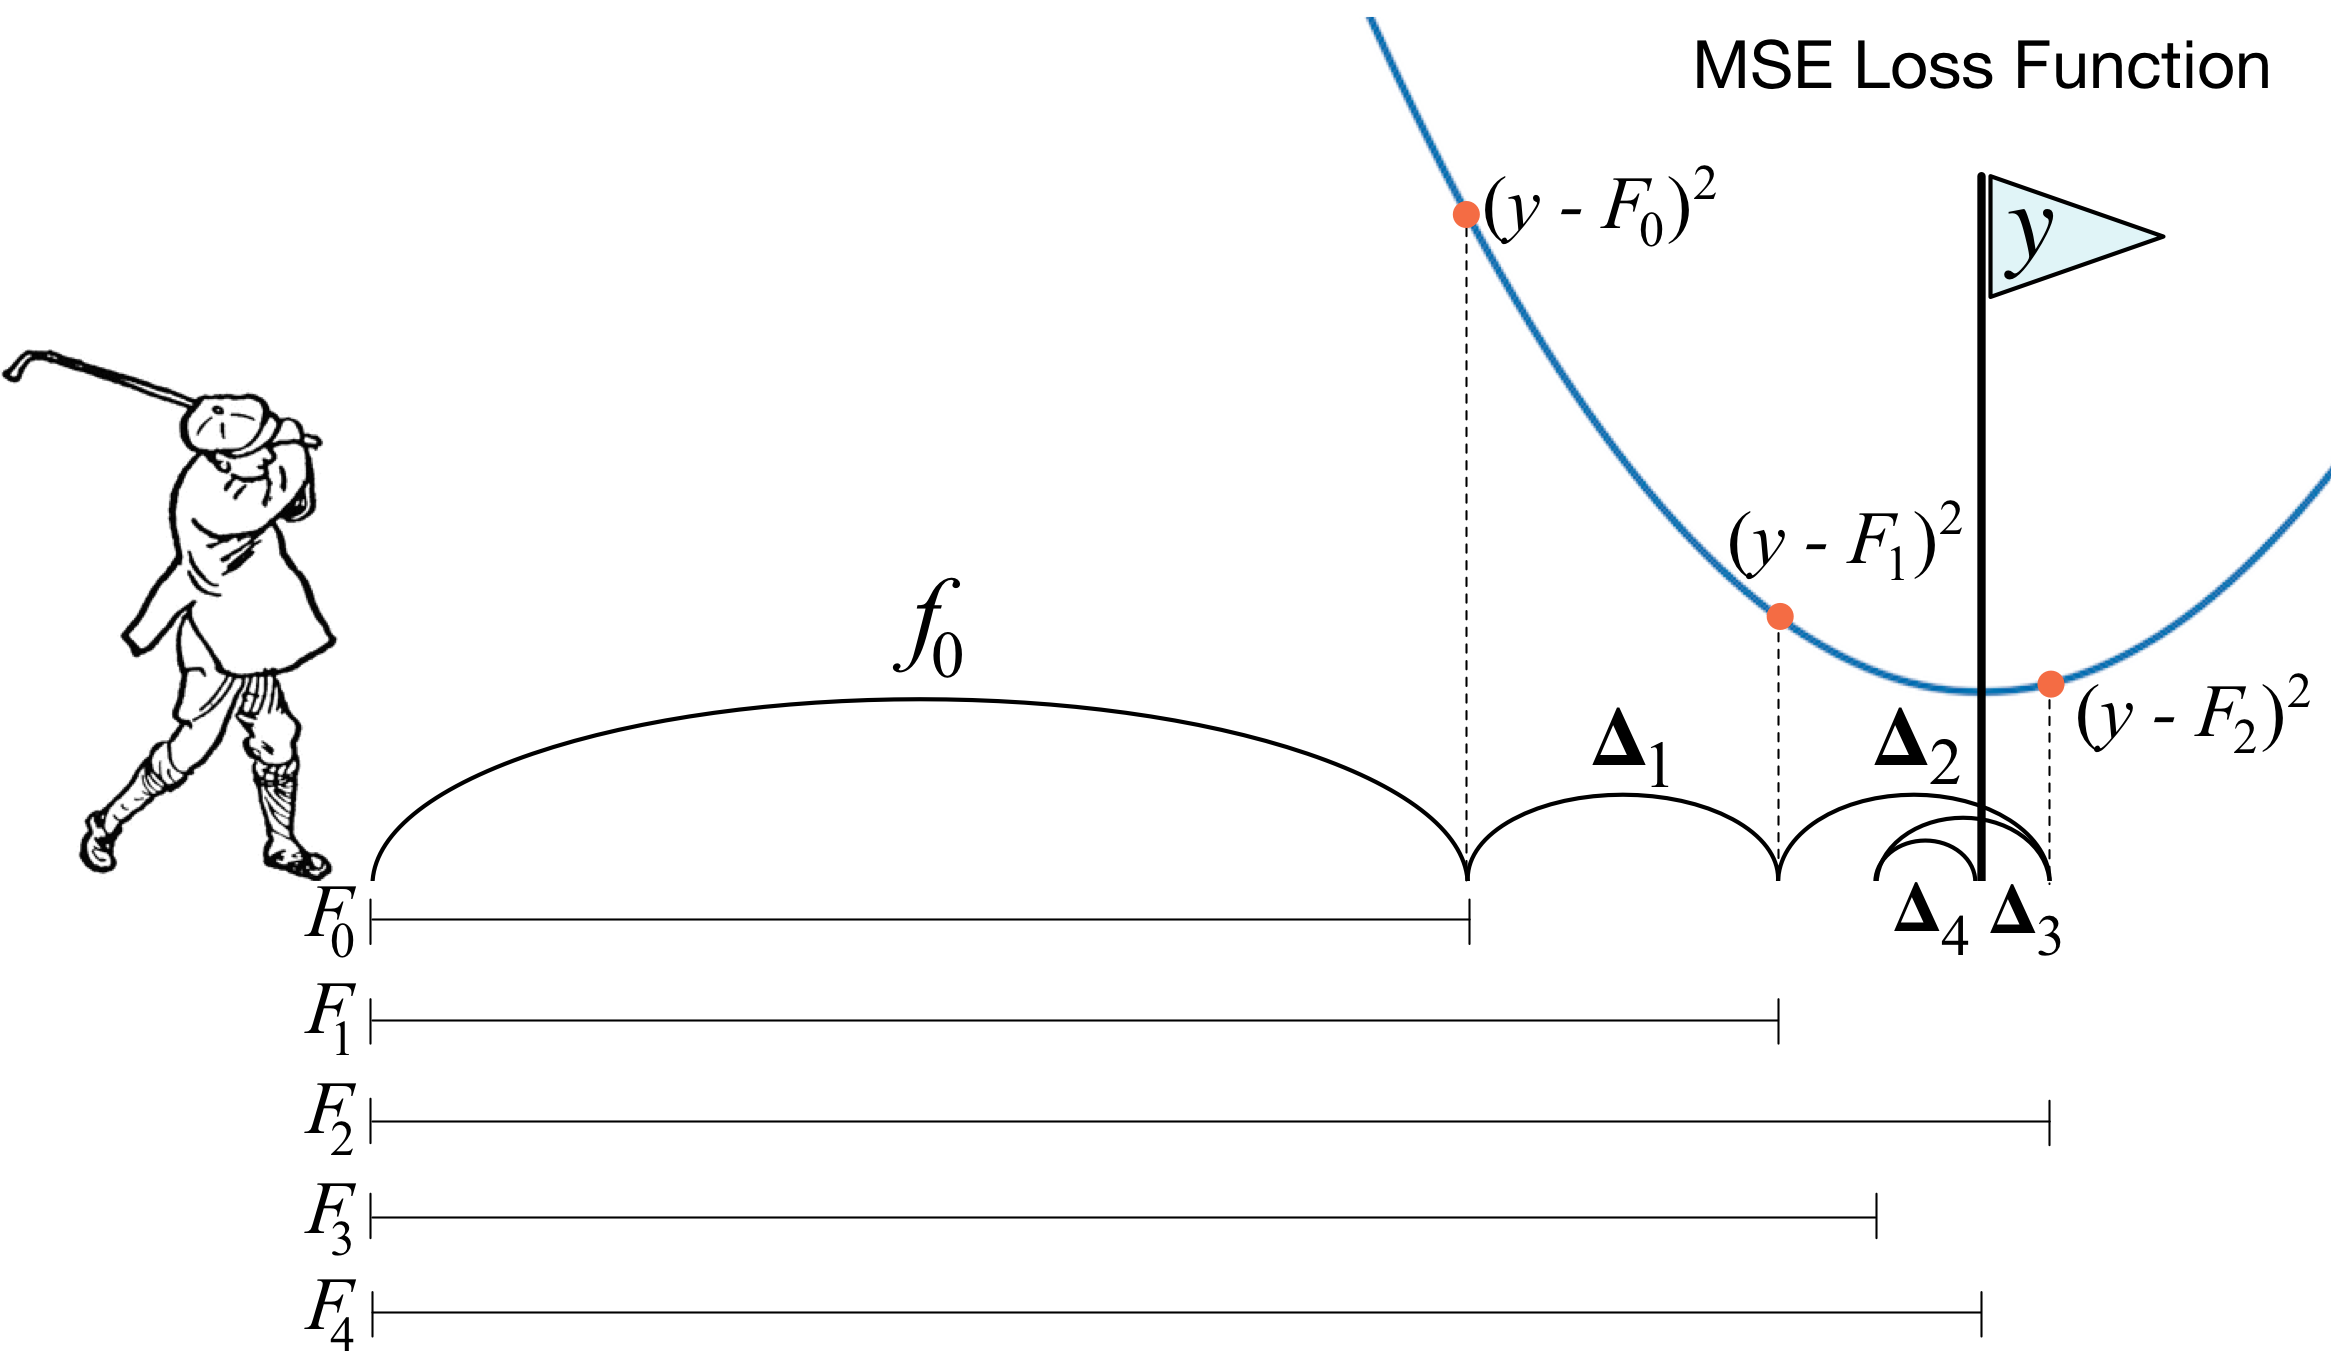

## Реализация обычного класса градиентного бустинга

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from sklearn import datasets
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
import itertools
%matplotlib inline

%load_ext Cython

%%cython -a 

import itertools
import numpy as np
cimport numpy as np
from itertools import *

cdef class RegressionTreeFastMse:
    
    cdef public int max_depth
    cdef public int feature_idx
    cdef public int min_size
    cdef public int averages 
    
    cdef public np.float64_t feature_threshold
    cdef public np.float64_t value

    cpdef RegressionTreeFastMse left
    cpdef RegressionTreeFastMse right
    
    def __init__(self, max_depth=3, min_size=4, averages=1):
        
        self.max_depth = max_depth
        self.min_size = min_size
        self.value = 0
        self.feature_idx = -1
        self.feature_threshold = 0
        self.left = None
        self.right = None
    
    def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):

        cpdef np.float64_t mean1 = 0.0
        cpdef np.float64_t mean2 = 0.0
        cpdef long N = X.shape[0]
        cpdef long N1 = X.shape[0]
        cpdef long N2 = 0
        cpdef np.float64_t delta1 = 0.0
        cpdef np.float64_t delta2 = 0.0
        cpdef np.float64_t sm1 = 0.0
        cpdef np.float64_t sm2 = 0.0
        cpdef list index_tuples
        cpdef list stuff
        cpdef long idx = 0
        
        cpdef np.float64_t prev_error1 = 0.0
        cpdef np.float64_t prev_error2 = 0.0
        cpdef long thres = 0
        cpdef np.float64_t error = 0.0
        
        cpdef np.ndarray[long, ndim=1] idxs
        
        cpdef np.float64_t x = 0.0
            
        # начальное значение - среднее значение y
        self.value = y.mean()
        # начальная ошибка - mse между значением в листе 
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0
        
        # пришли на максимальную глубину
        if self.max_depth <= 1:
            return
    
        dim_shape = X.shape[1]
        
        left_value, right_value = 0, 0
        
        for feat in range(dim_shape):
            
            prev_error1, prev_error2 = base_error, 0 
            idxs = np.argsort(X[:, feat])
            
            # переменные для быстрого переброса суммы
            mean1, mean2 = y.mean(), 0
            sm1, sm2 = y.sum(), 0
            
            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1

                idx = idxs[thres]
                x = X[idx, feat]
                
                # вычисляем дельты - по ним, в основном, будет делаться переброс
                delta1 = (sm1 - y[idx]) * 1.0 / N1 - mean1
                delta2 = (sm2 + y[idx]) * 1.0 / N2 - mean2

                # увеличиваем суммы
                sm1 -= y[idx]
                sm2 += y[idx]
                
                # пересчитываем ошибки за O(1)
                prev_error1 += (delta1**2) * N1 
                prev_error1 -= (y[idx] - mean1)**2 
                prev_error1 -= 2 * delta1 * (sm1 - mean1 * N1)
                mean1 = sm1/N1
                
                prev_error2 += (delta2**2) * N2 
                prev_error2 += (y[idx] - mean2)**2 
                prev_error2 -= 2 * delta2 * (sm2 - mean2 * N2)
                mean2 = sm2/N2
                
                # пропускаем близкие друг к другу значения
                if thres < N - 1 and np.abs(x - X[idxs[thres + 1], feat]) < 1e-5:
                    thres += 1
                    continue
                
                if (prev_error1 + prev_error2 < error):
                    if (min(N1,N2) > self.min_size):
                    
                        # переопределяем самый лучший признак и границу по нему
                        self.feature_idx, self.feature_threshold = feat, x
                        # переопределяем значения в листах
                        left_value, right_value = mean1, mean2

                        # флаг - значит сделали хороший сплит
                        flag = 1
                        error = prev_error1 + prev_error2
                                     
                thres += 1
        
        # ничего не разделили, выходим
        if self.feature_idx == -1:
            return
        
        # вызываем потомков дерева
        self.left = RegressionTreeFastMse(self.max_depth - 1)
        self.left.value = left_value
        self.right = RegressionTreeFastMse(self.max_depth - 1)
        self.right.value = right_value
        
        # новые индексы для обучения потомков
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
        
        # обучение потомков
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
    def __predict(self, np.ndarray[np.float64_t, ndim=1] x):
        
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):
            
        y = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

SyntaxError: invalid syntax (<ipython-input-12-af7839083b26>, line 17)

In [13]:
class GradientBoosting():
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 random_state=17, n_samples = 15, min_size = 5, base_tree='Bagging'):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0]])
        self.min_size = min_size
        self.loss_by_iter = []
        self.trees_ = []
        self.loss_by_iter_test = []
        self.n_samples = n_samples
        self.base_tree = base_tree

    
    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
        
        prediction = b.copy()
        
        for t in tqdm_notebook(range(self.n_estimators)):               
            
            if t == 0:
                resid = y
            else:
                # сразу пишем антиградиент
                resid = (y - prediction)
            
            # выбираем базовый алгоритм
            if self.base_tree == 'Bagging':
                tree = Bagging(max_depth=self.max_depth,
                                       min_size = self.min_size)                
            if self.base_tree == 'Tree':
                tree = RegressionTreeFastMse(max_depth=self.max_depth,
                                          min_size = self.min_size)
                
            # обучаемся на векторе антиградиента
            tree.fit(X, resid)
            # делаем предикт и добавляем алгоритм к ансамблю
            b = tree.predict(X).reshape([X.shape[0]])
            self.trees_.append(tree)
            prediction += self.learning_rate * b
            # добавляем только если не первая итерация
            if t > 0:
                self.loss_by_iter.append(mse(y,prediction))
                   
        return self
    
    def predict(self, X):
        
        # сначала прогноз – это просто вектор из средних значений ответов на обучении
        pred = np.ones([X.shape[0]]) * np.mean(self.y)
        # добавляем прогнозы деревьев
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape([X.shape[0]])
            
        return pred

Построим теперь кривую лосса на обучающей выборке, чтобы убедиться, что при каждой итерации у нас действительно происходит его уменьшение.

In [14]:
GDB = GradientBoosting(n_estimators=50)
GDB.fit(X,y)
x = GDB.predict(X)
plt.grid()
plt.title('Loss by iterations')
plt.plot(GDB.loss_by_iter)

NameError: name 'X' is not defined

## Бэггинг над решающими деревьями

Отлично, перед тем как сравнивать результаты, давайте поговорим ещё и о процедуре бэггинга над деревьями.

Тут вс просто: мы хотим защититься от переобучения, и поэтому с помощью выборок с возращением будем усреднять наши предсказания, чтобы случайно не напороться на выбросы (почему это так работает — лучше почитайте по ссылке).

In [15]:
class Bagging():
    
    '''
    Класс Bagging - предназначен для генерирования бустрапированного
    выбора моделей.
    '''
    
    def __init__(self, max_depth = 3, min_size=10, n_samples = 10):
            
        #super(CART, self).__init__()
        self.max_depth = max_depth
        self.min_size = min_size
        self.n_samples = n_samples
        self.subsample_size = None
        self.list_of_Carts = [RegressionTreeFastMse(max_depth=self.max_depth, 
                                min_size=self.min_size) for _ in range(self.n_samples)]

    def get_bootstrap_samples(self, data_train, y_train):
        
        # генерируем индексы выборок с возращением
        indices = np.random.randint(0, len(data_train), (self.n_samples, self.subsample_size))
        samples_train = data_train[indices]
        samples_y = y_train[indices]
        return samples_train, samples_y
    
    def fit(self, data_train, y_train):
        
        # обучаем каждую модель 
        self.subsample_size = int(data_train.shape[0])
        samples_train, samples_y = self.get_bootstrap_samples(data_train, y_train)
        for i in range(self.n_samples):
            self.list_of_Carts[i].fit(samples_train[i], samples_y[i].reshape(-1))
        return self
        
    def predict(self, test_data):
        
        # для каждого объекта берём его средний предикт
        num_samples = test_data.shape[0]
        pred = []
        for i in range(self.n_samples):
            pred.append(self.list_of_Carts[i].predict(test_data))
        pred = np.array(pred).T

        return np.array([np.mean(pred[i]) for i in range(num_samples)])
    

## Результаты

In [16]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GDBSklearn
import copy

def get_metrics(X,y,n_folds=2, model=None):
    kf = KFold(n_splits=n_folds, shuffle=True)
    kf.get_n_splits(X)

    er_list = []
    for train_index, test_index in tqdm_notebook(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
        er_list.append(mse(y_test, predict))
    
    return er_list

data = datasets.fetch_california_housing()
X = np.array(data.data)
y = np.array(data.target)
er_boosting = get_metrics(X,y,30,GradientBoosting(max_depth=3, n_estimators=40, base_tree='Tree' ))
er_boobagg = get_metrics(X,y,30,GradientBoosting(max_depth=3, n_estimators=40, base_tree='Bagging' ))
er_sklearn_boosting = get_metrics(X,y,30,GDBSklearn(max_depth=3,n_estimators=40, learning_rate=0.1))

%matplotlib inline
data = [er_sklearn_boosting, er_boosting, er_boobagg]
fig7, ax7 = plt.subplots()
ax7.set_title('')
ax7.boxplot(data, labels=['Sklearn Boosting', 'Boosting', 'BooBag'])
plt.grid()
plt.show()

NameError: name 'datasets' is not defined

## XGBoost

In [17]:
%%cython -a 

import numpy as np
cimport numpy as np

cdef class RegressionTreeGain:
    cdef public int max_depth
    cdef public np.float64_t gain
    cdef public np.float64_t lmd
    cdef public np.float64_t gmm
    
    cdef public int feature_idx
    cdef public int min_size

    cdef public np.float64_t feature_threshold
    cdef public np.float64_t value
    
    cpdef public RegressionTreeGain left
    cpdef public RegressionTreeGain right
    
    def __init__(self, int max_depth=3, np.float64_t lmd=1.0, np.float64_t gmm=0.1, min_size=5):
        self.max_depth = max_depth
        self.gmm = gmm
        self.lmd = lmd
        self.left = None
        self.right = None
        self.feature_idx = -1
        self.feature_threshold = 0
        self.value = -1e9
        self.min_size = min_size
        
        return
    
    def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):
        
        cpdef long N = X.shape[0]
        cpdef long N1 = X.shape[0]
        cpdef long N2 = 0
        cpdef long idx = 0
        cpdef long thres = 0
        cpdef np.float64_t gl, gr, gn
        cpdef np.ndarray[long, ndim=1] idxs
        cpdef np.float64_t x = 0.0
        cpdef np.float64_t best_gain = -self.gmm
        
        if self.value == -1e9:
            self.value = y.mean()
        
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0
        
        if self.max_depth <= 1:
            return
        
        dim_shape = X.shape[1]
        
        left_value = 0
        right_value = 0
        
        # начинаем процесс обучения
        # чуть-чуть матана - у нас mse, L = (y - pred)**2
        # dL/dpred = pred - y, эту разницу мы в бустинге будем передавать со знаком -
        # dL^2/d^2pred = 1 - получается, это просто количество объектов в листе
        
        for feat in range(dim_shape):
            
            idxs = np.argsort(X[:, feat])
             
            gl,gr = y.sum(),0.0

            N1, N2, thres = N, 0, 0
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1

                idx = idxs[thres]
                x = X[idx, feat]
                
                gl -= y[idx]
                gr += y[idx]
                
                # считаем гейн
                gn = (gl**2) / (N1 + self.lmd)  + (gr**2) / (N2 + self.lmd)
                gn -= ((gl + gr)**2) / (N1 + N2 + self.lmd) + self.gmm
                
                if thres < N - 1 and x == X[idxs[thres + 1], feat]:
                    thres += 1
                    continue
                
                # проверяем условия на гейн
                if (gn > best_gain) and (min(N1,N2) > self.min_size):
                    
                    flag = 1
                    best_gain = gn
                    left_value = -gl / (N1 + self.lmd)
                    right_value = -gr / (N2 + self.lmd)
                    
                    self.feature_idx = feat
                    self.feature_threshold = x

                thres += 1
        
        self.gain = best_gain
        if self.feature_idx == -1:
            return
                
        self.left = RegressionTreeGain(max_depth=self.max_depth - 1, gmm=self.gmm, lmd=self.lmd)
        self.left.value = left_value
        self.right = RegressionTreeGain(max_depth=self.max_depth - 1, gmm=self.gmm, lmd=self.lmd)
        self.right.value = right_value
        
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
    
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
        # подрубаем отрицательный гейн
        if (self.left.left == None or self.right.left == None):
            if self.gain < 0.0:
                self.left = None
                self.right = None
                self.feature_idx = -1

    def __predict(self, np.ndarray[np.float64_t, ndim=1] x):
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
             return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

UsageError: Cell magic `%%cython` not found.


Слегка модифицируем наш бустинг, сделаем некоторые параметры адаптивными. Например, если замечаем, что лосс начал выходить на плато, то уменьшаем learning rate и увеличиваем max_depth у следующих эстиматоров. Также добавим новый бэггинг — теперь сделаем бустинг над бэггингами из деревьев с gain'ом:

In [18]:
class Bagging():
    
    def __init__(self, max_depth = 3, min_size=5, n_samples = 10):
            
        self.max_depth = max_depth
        self.min_size = min_size
        self.n_samples = n_samples
        self.subsample_size = None
        self.list_of_Carts = [RegressionTreeGain(max_depth=self.max_depth, 
                                min_size=self.min_size) for _ in range(self.n_samples)]

    
    def get_bootstrap_samples(self, data_train, y_train):
        
        indices = np.random.randint(0, len(data_train), (self.n_samples, self.subsample_size))
        samples_train = data_train[indices]
        samples_y = y_train[indices]
        return samples_train, samples_y
    
    def fit(self, data_train, y_train):
        
        self.subsample_size = int(data_train.shape[0])
        samples_train, samples_y = self.get_bootstrap_samples(data_train, y_train)
        for i in range(self.n_samples):
            self.list_of_Carts[i].fit(samples_train[i], samples_y[i].reshape(-1))
        return self
        
    def predict(self, test_data):
        
        num_samples = test_data.shape[0]
        pred = []
        for i in range(self.n_samples):
            pred.append(self.list_of_Carts[i].predict(test_data))
        pred = np.array(pred).T

        return np.array([np.mean(pred[i]) for i in range(num_samples)])

In [19]:
class GradientBoosting():
    

    def __init__(self, n_estimators=100, learning_rate=0.2, max_depth=3, 
                 random_state=17, n_samples = 15, min_size = 5, base_tree='Bagging'):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0]])
        self.min_size = min_size
        self.loss_by_iter = []
        self.trees_ = []
        self.loss_by_iter_test = []
        self.n_samples = n_samples
        self.base_tree = base_tree

        # хотим как-то регулировать работу алгоритма на поздних итерациях
        # если ошибка застряла, то уменьшаем lr и увеличиваем max_depth
        self.add_to_max_depth = 1
        self.init_mse_board = 1.5
    
    def fit(self, X, y):
        print (self.base_tree)
        self.X = X
        self.y = y
        b = self.initialization(y)
        
        prediction = b.copy()
        
        for t in tqdm_notebook(range(self.n_estimators)):
                        
            if t == 0:
                resid = y
            else:
                resid = (y - prediction)
                if (mse(temp_resid,resid) < self.init_mse_board):
                    self.init_mse_board /= 1.5
                    self.add_to_max_depth += 1
                    self.learning_rate /= 1.1
                    # print ('Alert!', t, self.add_to_max_depth)
            
            if self.base_tree == 'Bagging':
                tree = Bagging(max_depth=self.max_depth+self.add_to_max_depth,
                                         min_size = self.min_size)
                resid = -resid
                
            if self.base_tree == 'Tree':
                tree = RegressionTreeFastMse(max_depth=self.max_depth+self.add_to_max_depth, min_size = self.min_size)
                
            if self.base_tree == 'XGBoost':
                tree = RegressionTreeGain(max_depth=self.max_depth+self.add_to_max_depth, min_size = self.min_size)
                resid = -resid
                
            tree.fit(X, resid)
            b = tree.predict(X).reshape([X.shape[0]])
            # print (b.shape)
            self.trees_.append(tree)
            prediction += self.learning_rate * b
            temp_resid = resid

        return self
    
    def predict(self, X):
        
        # сначала прогноз – это просто вектор из средних значений ответов на обучении
        pred = np.ones([X.shape[0]]) * np.mean(self.y)
        # добавляем прогнозы деревьев
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape([X.shape[0]])
            
        return pred

## Результаты

In [20]:
data = datasets.fetch_california_housing()
X = np.array(data.data)
y = np.array(data.target)

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GDBSklearn

er_boosting_bagging = get_metrics(X,y,30,GradientBoosting(max_depth=3, n_estimators=150,base_tree='Bagging'))
er_boosting_xgb = get_metrics(X,y,30,GradientBoosting(max_depth=3, n_estimators=150,base_tree='XGBoost'))
er_sklearn_boosting = get_metrics(X,y,30,GDBSklearn(max_depth=3,n_estimators=150,learning_rate=0.2))

%matplotlib inline
data = [er_sklearn_boosting, er_boosting_xgb, er_boosting_bagging]
fig7, ax7 = plt.subplots()
ax7.set_title('')
ax7.boxplot(data, labels=['GdbSklearn', 'Xgboost',  'XGBooBag'])
plt.grid()
plt.show()

NameError: name 'datasets' is not defined

## Hyperopt и xgboost: Пример поиска гиперпараметров с помощью Hyperopt для xgboost

Xgboost пожалуй самая популярная библиотека градиентного бустинга, поэтому именно на её примере покажу как можно улучшить качество простым техническим приёмом — автоматическим подбором параметров. Чтобы не усложнять поиск оптимальных гиперпараметров, возьмем лишь несколько основных: n_estimators, eta и max_depth. Основная идея библиотеки hyperopt — это построение математической гипотезы о том как выглядит функция результа на множества параметров и проверка этой гипотезы с каждой итерацией. Т.к. перебор и обучение может быть весьма продолжительны — то на вход задается количество итерации, после которого происходит остановка поиска. Но все равно предсказать, когда закончится поиск проблематично т.к. при разных гиперпараметрах обучение и предсказание занимает разное время. Поэтому я и советую начинать с небольшого количества итерации и небольшого количества параметров. К сожалению останова по истечению заранее заданного времени нет, поэтому мощный комьютер для data-sciece вам в руки и вперед!

Статья: http://zabaykin.ru/?p=600

In [21]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
 
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
 
# Для теста возьмем классический сет "ирисы Фишера"
# Разумеется вместо X и y Вам следует взять свои фичи и таргет
iris = datasets.load_iris()
X = iris.data
y = iris.target
 
 
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X, y, cv=3).mean()
    print(current_score, params)
    return -current_score
 
 
simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
}
 
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

ModuleNotFoundError: No module named 'xgboost'

Как видимо нет ничего сложного, главное определить:

- пространство параметров, внутри которых hyperopt будет оптимизировать
- функцию оценки.

Обратите внимание, что в функции оценки возвращается результат со знаком минус — это сделано специально, т.к. гиперопт минимизирует функционал, а нам надо максимизировать точность.
Для построения пространства в основном используется либо набор возможных значений (hp.choice) либо отрезок в пространстве R hp.quniform(label, low, high, q), где q округление.
Для тех, кто планирует более мощную настройку, оставлю space более мощный для XGB.

In [22]:
space_xgb2 = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            # Increase this number if you have more cores. Otherwise, remove it and it will default
            # to the maxium number.
            'nthread': 4,
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1
        }

NameError: name 'hp' is not defined

Теперь с помощью данного поста Вы можете построить оптимизацию гиперпараметров не ограничиваясь xgboost.